In [2]:
import os
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input

In [4]:
TRAINING_DIR = 'data/training/'
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=30,
                                  zoom_range=0.4,
                                  horizontal_flip=True)

In [5]:
img_width = 128; img_height=128
batch_size = 64

In [7]:
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width)
                                                    )

Found 60646 images belonging to 15 classes.


In [8]:
VALIDATION_DIR = 'data/validation/'
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                   batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 6738 images belonging to 15 classes.


In [9]:
callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
best_model_file = 'data/resnet101_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose=1, save_best_only=True)

In [11]:
# Set pretrained weight
#wp = 'data/resnet101_weights_tf.h5'
# Build base model
resnet101_base = ResNet101(include_top=False, weights='imagenet',
                          input_tensor=None, input_shape= (img_height, img_width, 3))

171450368/171446536 [==============================] - 17s 0us/step


In [16]:
print('Adding new layers...')
output = resnet101_base.get_layer(index= -1).output
output = Flatten()(output)
output = Dense(512, activation = 'relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(512, activation = 'relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(15, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [17]:
resnet101_model = Model(resnet101_base.input, output)
for layer in resnet101_model.layers[:-7]:
    layer.trainable = False
    
resnet101_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
resnet101_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = resnet101_model.fit_generator(train_generator, epochs=50, verbose=1, 
                                       validation_data = validation_generator,
                                       callbacks = [callbacks, best_model])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 948 steps, validate for 106 steps
Epoch 1/50
947/948 [============================>.] - ETA: 2s - loss: 1.6575 - accuracy: 0.4624
Epoch 00001: val_accuracy improved from -inf to 0.51291, saving model to data/resnet101_drop_batch_best_weights_256.h5
948/948 [==============================] - 3030s 3s/step - loss: 1.6573 - accuracy: 0.4625 - val_loss: 1.6501 - val_accuracy: 0.5129
Epoch 2/50
947/948 [============================>.] - ETA: 3s - loss: 1.3906 - accuracy: 0.5305
Epoch 00002: val_accuracy improved from 0.51291 to 0.56842, saving model to data/resnet101_drop_batch_best_weights_256.h5
948/948 [==============================] - 3203s 3s/step - loss: 1.3905 - accuracy: 0.5306 - val_loss: 1.3838 - val_accuracy: 0.5684
Epoch 3/50
947/948 [============================>.] - ETA: 3s - loss: 1.3208 - accuracy: 0.5527
Epoch 00003: val_accuracy did not i

In [20]:
target_dir = 'data'
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

resnet101_model.save(target_dir + 'resnet101_model.h5')
resnet101_model.save_weights(target_dir + 'resnet101_weights.h5')

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

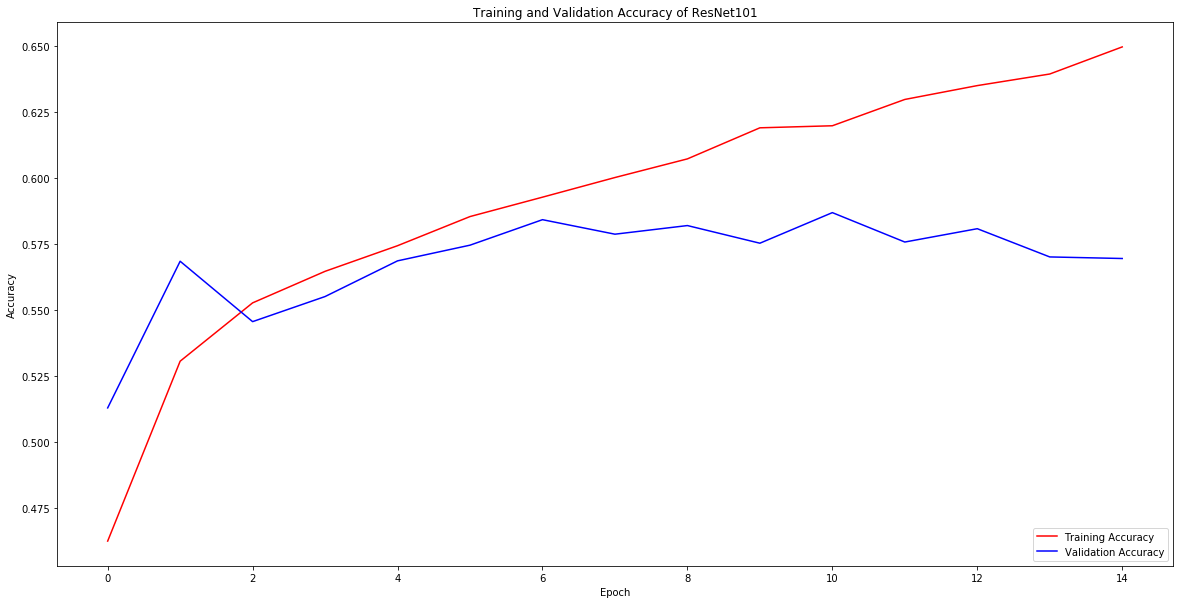

In [21]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of ResNet101')
plt.legend(loc='lower right')
plt.show()
fig.savefig('data/Accuracy_curve_resnet101_drop_batch_256.jpg')

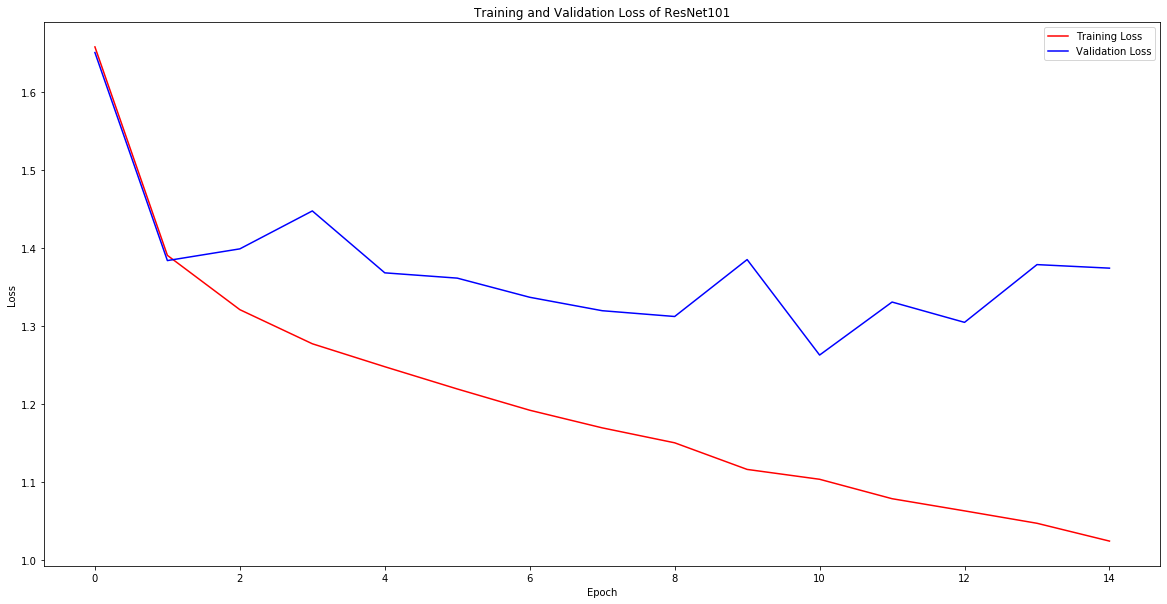

In [22]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of ResNet101')
plt.legend(loc='upper right')
plt.show()
fig.savefig('data/Loss_curve_resnet101_drop_batch_256.jpg')